# Classical SVR with 20 training points that can be compared to the QSVR

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from dimod import ExactSolver
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from utils import nb_utils
from joblib import dump, load
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import datetime
from sklearn.svm import SVR
from random import randint

Total runs: 1000
Best r2: 0.9587735289921824
Worst r2: 0.2160885832006183
Mean r2: 0.890168883954042
Std r2: 0.052079889303832234
Median r2: 0.9028069682428714


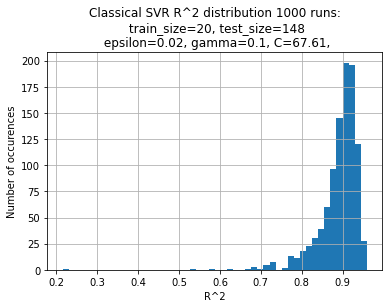

In [29]:
# load data
df_info = nb_utils.get_df_info('mlpf')
df = pd.read_csv(df_info['df_path'])
df = df.drop(df[df.loss_99 == df.loss_99.max()].index)

# Select features
curve = nb_utils.get_curve(df_info=df_info, known_curve=0.25, df=df)
X = curve[:,[i for i in range(0,curve.shape[1],2)]]

# Prediction target
y = nb_utils.get_target(df_info,df)

# Scale data
x_scaler = QuantileTransformer(n_quantiles=50,random_state=0)
X = x_scaler.fit_transform(X)
y_scaler =  QuantileTransformer(n_quantiles=50,random_state=0)
y = y_scaler.fit_transform(y.reshape(-1, 1)).ravel()


rs = randint(0, 2**30)
num_runs = 1000
r2 = np.zeros((num_runs, 1))
for i in range(num_runs):
	# train test split
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=rs+i)
	X_train = X_train[:20,:]
	y_train = y_train[:20]
	
	# QSVR code
	model = SVR(epsilon = 0.02, gamma=0.1, C=67.61) # instantiate
	#RUN ON D-WAVE
	model.fit(X_train, y_train)
	# evaluate SVR
	y_pred = model.predict(X_test)
	r2[i] = r2_score(y_pred,y_test)
	#print(f'Finished run {i} with r2 = {r2[i,:]}')

print(f'Total runs: {num_runs}')
print(f'Best r2: {r2.max()}')
print(f'Worst r2: {r2.min()}')
print(f'Mean r2: {r2.mean()}')
print(f'Std r2: {r2.std()}')
print(f'Median r2: {np.median(r2)}')

plt.hist(r2,bins = 50)
plt.grid()
plt.title('Classical SVR R^2 distribution 1000 runs:\n train_size=20, test_size=148\n epsilon=0.02, gamma=0.1, C=67.61,')
plt.ylabel('Number of occurences')
plt.xlabel('R^2')
plt.show()